In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import networkx as nx
import sys
import os
import pandas as pd
import spycon
import glob

#https://github.com/christiando/spycon
#requires pip install git+https://github.com/christiando/spycon
#https://github.com/pwollstadt/IDTxl
#requires pip install git+https://github.com/pwollstadt/IDTxl
import spycon_utils

from typing import Tuple

from sklearn.cluster import DBSCAN

sys.path.append("..")
from analysis_package import maxlab_analysis as mla

In [4]:
day = 34
chip = "M07480"
well_no = 1
pre_time = 20 #In theory, these can be extracted from events.
train_time = 20
post_time = 20

remote_drive_path = "R:/"
remote_drive_path = "/run/user/1000/gvfs/smb-share:server=rstoreint.it.tufts.edu,share=as_rsch_levinlab_wclawson01$/"
file_path = f"{remote_drive_path}/Experimental Data/Summer 2024/stim_removal/DIV{day}_stim_removal/{chip}/"
file_path = glob.glob(file_path + "/*/")[-1] #date
file_path = glob.glob(file_path + "/*/")[-1] #trial
file_path = file_path + f"well{well_no}/"

file_name = f"DIV{day}_stim_removal_well_{well_no}.raw.h5"

recording_no = 0

In [5]:
def load_data(
    path: str,
    well_no: int,
    recording_no: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    spikes = mla.load_spikes_from_file(path, well_no, recording_no)
    mapping = mla.load_mapping(path, well_no, recording_no)

    # for i in spikes.index:
    #     if spikes.loc[i, "channel"] not in mapping["channel"]:
    #         spikes.drop(i)
    spikes = spikes.loc[spikes["channel"].isin(mapping["channel"]), :]
    return spikes, mapping


spike_pd_df, mapping_pd_df = load_data(file_path + file_name,
                                        well_no,
                                        recording_no,)

spike_pd_df = spike_pd_df.loc[spike_pd_df["time"] < pre_time * 60]

display(spike_pd_df)

,time,channel,amplitude
0,-1.3111,729,-4.741617
1,-1.3074,735,-9.319642
2,-1.2743,735,-10.077305
3,-0.5580,67,-4.237706
4,-0.5020,325,-3.324919
...,...,...,...
2834439,1199.8986,34,13.826529
2834440,1199.8988,114,-4.962593
2834441,1199.8994,114,4.521870
2834442,1199.9097,98,-4.238306


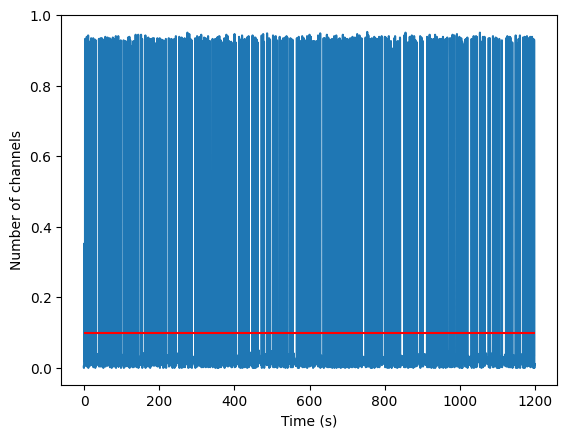

/home/mxwbio/Desktop/nathan_senior_project/HDMEA-func-connectivity/analysis_package/maxlab_analysis.py:406: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  synchronized_bursts_df = pd.concat([synchronized_bursts_df, entries_in_range])


,time,channel,amplitude
0,-1.3111,729,-4.741617
1,-1.3074,735,-9.319642
2,-1.2743,735,-10.077305
3,-0.5580,67,-4.237706
4,-0.5020,325,-3.324919
...,...,...,...
79859,1199.8986,34,13.826529
79860,1199.8988,114,-4.962593
79861,1199.8994,114,4.521870
79862,1199.9097,98,-4.238306


In [6]:
if True:
    burst_spike_df, spike_times = mla.find_synchronized_bursts(spike_pd_df, plot_firing = True, delta_t = 0.5, fraction_threshold = 0.1)
    spike_pd_df = spike_pd_df.drop(burst_spike_df.index, axis = 0).reset_index(drop = True)
spike_pd_df

In [7]:
#for t in spike_times:
#    spike_pd_df = spike_pd_df.drop(burst_spike_df.loc[burst_spike_df["time"] > t - 0.1] & burst_spike_df.loc[burst_spike_df["time"] < t + 0.3] )

In [8]:
spike_pd_df

,time,channel,amplitude
0,-1.3111,729,-4.741617
1,-1.3074,735,-9.319642
2,-1.2743,735,-10.077305
3,-0.5580,67,-4.237706
4,-0.5020,325,-3.324919
...,...,...,...
79859,1199.8986,34,13.826529
79860,1199.8988,114,-4.962593
79861,1199.8994,114,4.521870
79862,1199.9097,98,-4.238306


In [9]:
#calculate num spikes
spike_pd_df.groupby(["channel"]).count()

,time,amplitude
channel,,
0,7,7
1,193,193
2,130,130
3,119,119
4,13,13
...,...,...
993,44,44
1001,6,6
1009,14,14


In [10]:
grouped_counts = spike_pd_df.groupby(["channel"])["channel"].count()
grouped_mean_amps = spike_pd_df.groupby(["channel"])["amplitude"].mean()

for i in mapping_pd_df.index:
    try:
        mapping_pd_df.loc[i, "num_spikes"] =grouped_counts[mapping_pd_df.loc[i, "channel"]]
        mapping_pd_df.loc[i, "mean amp"] = np.abs(grouped_mean_amps.loc[mapping_pd_df.loc[i, "channel"]])
    except Exception as err:
        print(err)
        mapping_pd_df.loc[i, "num_spikes"] = 0
        mapping_pd_df.loc[i, "mean amp"] = 0
        

display(mapping_pd_df)

40
157
204
594
705
817
917


,channel,electrode,x,y,num_spikes,mean amp
0,0,13001,367.5,1032.5,7.0,1.860811
1,1,15799,3132.5,1242.5,193.0,2.054668
2,2,12557,297.5,997.5,130.0,1.245918
3,3,16253,3377.5,1277.5,119.0,1.788049
4,4,13461,717.5,1067.5,13.0,5.340375
...,...,...,...,...,...,...
501,993,11357,2397.5,892.5,44.0,0.341589
502,1001,4783,2852.5,367.5,6.0,5.384850
503,1009,7849,2607.5,612.5,14.0,4.402768
504,1015,17967,2572.5,1417.5,43.0,3.097333


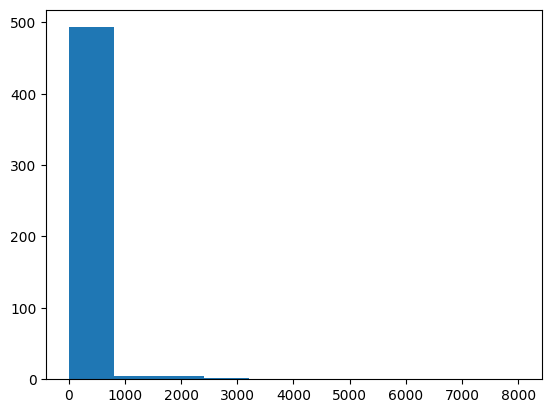

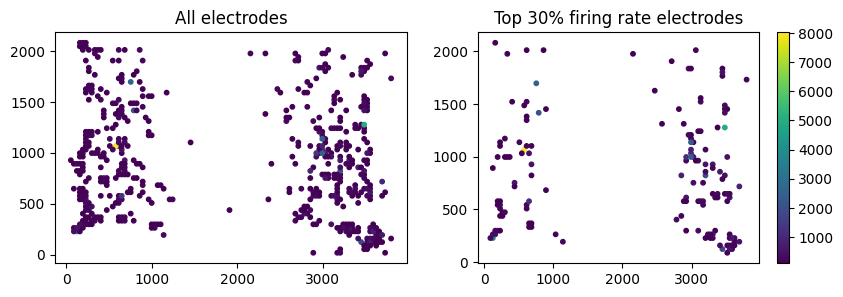

In [11]:
#Cluster points
#17.5 x sqrt(2) = 24.8

freq_percentile = 70 #THIS IS ADJUSTABLE

plt.hist(mapping_pd_df.loc[:, "num_spikes"])

plt.figure(figsize = [10, 3])
plt.subplot(121)
plt.title("All electrodes")
plt.scatter(mapping_pd_df.loc[:, "x"], mapping_pd_df.loc[:, "y"],  s = 10, c = mapping_pd_df.loc[:, "num_spikes"])

plt.subplot(122)
plt.title(f"Top {100 - freq_percentile}% firing rate electrodes")
freq_trimmed_indices = mapping_pd_df["num_spikes"] > np.percentile(mapping_pd_df["num_spikes"], freq_percentile)
plt.scatter(mapping_pd_df.loc[freq_trimmed_indices, "x"], mapping_pd_df.loc[freq_trimmed_indices, "y"],  s = 10, c = mapping_pd_df.loc[freq_trimmed_indices, "num_spikes"])
plt.colorbar()

plt.show()


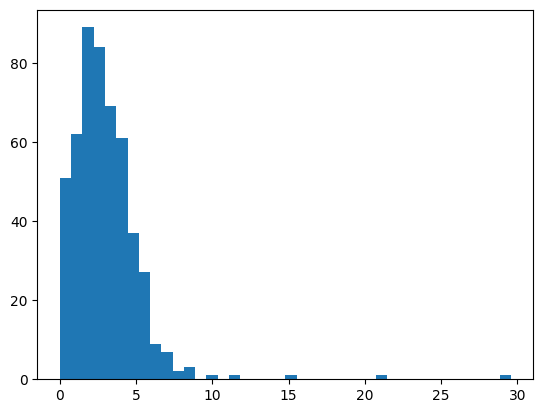

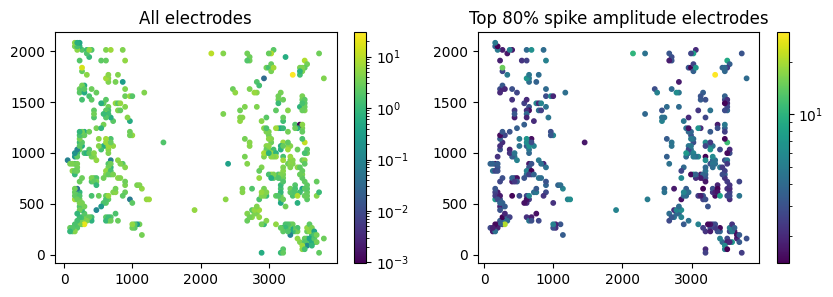

In [12]:
amp_percentile = 20
plt.hist(mapping_pd_df.loc[:, "mean amp"], 40)

plt.figure(figsize = [10, 3])
plt.subplot(121)
plt.title("All electrodes")

plt.scatter(mapping_pd_df.loc[:, "x"], mapping_pd_df.loc[:, "y"],  s = 10, c = mapping_pd_df.loc[:, "mean amp"], norm=mpl.colors.LogNorm())
plt.colorbar()

plt.subplot(122)
plt.title(f"Top {100 - amp_percentile}% spike amplitude electrodes")
amp_trimmed_indices = mapping_pd_df["mean amp"] > np.percentile(mapping_pd_df["mean amp"], amp_percentile)
plt.scatter(mapping_pd_df.loc[amp_trimmed_indices, "x"], mapping_pd_df.loc[amp_trimmed_indices, "y"],  s = 10, c = mapping_pd_df.loc[amp_trimmed_indices, "mean amp"], norm=mpl.colors.LogNorm())
plt.colorbar()
plt.show()

123
123
123
[ 0  1  2  3  0  2  4  5  6  7  8  9 10 11 12  6 13 14 15 16 17 18 19 20
 21 22 23 24 25 24 25 24 24 17 25 26 27 28 19 29 20 27 30  6 31 25 31 31
 25 32 33 32 25 33 34 25 35 25 36 33 33 29 37 18 38 37 32 37 32 23 31 39
 40 31 31  6 21 41 42  2  5 43 44 45 43 20 46 47 48 21 43 49 50 51 52  2
 53 54 55 56 57 21 11 58 48 59 45 60 61 62 62  6 18 35 55 62 63 64 65  2
 66 67 68]
68
123


/tmp/ipykernel_1824205/807916104.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trimmed_mapping_pd_df["label"] = labels


,channel,electrode,x,y,num_spikes,mean amp
0,0,13001,367.5,1032.5,7.0,1.860811
1,1,15799,3132.5,1242.5,193.0,2.054668
2,2,12557,297.5,997.5,130.0,1.245918
3,3,16253,3377.5,1277.5,119.0,1.788049
4,4,13461,717.5,1067.5,13.0,5.340375
...,...,...,...,...,...,...
501,993,11357,2397.5,892.5,44.0,0.341589
502,1001,4783,2852.5,367.5,6.0,5.384850
503,1009,7849,2607.5,612.5,14.0,4.402768
504,1015,17967,2572.5,1417.5,43.0,3.097333


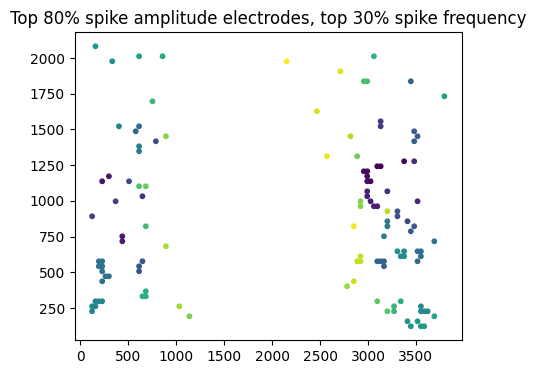

In [13]:
#Combined 50 percent???
trimmed_indices = freq_trimmed_indices & amp_trimmed_indices
print(np.sum(trimmed_indices))
plt.figure(figsize = (5, 4))
plt.title(f"Top {100 - amp_percentile}% spike amplitude electrodes, top {100 - freq_percentile}% spike frequency")

trimmed_mapping_pd_df = mapping_pd_df.loc[trimmed_indices, :]
clustering = DBSCAN(eps = 50, min_samples = 1).fit(trimmed_mapping_pd_df.loc[:, ["x", "y"]])
labels = clustering.labels_
trimmed_mapping_pd_df["label"] = labels

print(len(trimmed_mapping_pd_df))
print(len(labels))
print(labels)
print(max(labels))
print(len(trimmed_mapping_pd_df.loc[:, "x"]))
plt.scatter(mapping_pd_df.loc[trimmed_indices, "x"], mapping_pd_df.loc[trimmed_indices, "y"],  s = 10,  c = labels)
mapping_pd_df

In [14]:
spike_pd_df_channel_replaced = spike_pd_df.loc[spike_pd_df["channel"].isin(mapping_pd_df.loc[trimmed_indices, "channel"]), :]
spike_pd_df_channel_replaced

,time,channel,amplitude
1,-1.3074,735,-9.319642
2,-1.2743,735,-10.077305
3,-0.5580,67,-4.237706
4,-0.5020,325,-3.324919
5,-0.4232,67,-4.048513
...,...,...,...
79857,1199.7420,325,-4.004916
79860,1199.8988,114,-4.962593
79861,1199.8994,114,4.521870
79862,1199.9097,98,-4.238306


In [15]:
clustering_dict = dict()
for i, chan in enumerate(trimmed_mapping_pd_df["channel"]):
    clustering_dict[chan] = labels[i]
clustering_dict
print(max(clustering_dict.values()))

68


In [16]:
mapping_pd_df_channel_replaced = trimmed_mapping_pd_df.drop(["channel"], axis = 1).rename(columns = {"label": "channel"})
mapping_pd_df_channel_replaced = mapping_pd_df_channel_replaced.groupby("channel").mean().reset_index(drop = True)
#mapping_pd_df_channel_replaced.set_index("channel", inplace=True)
display(mapping_pd_df_channel_replaced)

,electrode,x,y,num_spikes,mean amp
0,15798.0,3115.0,1242.5,164.0,4.420792
1,16253.0,3377.5,1277.5,119.0,1.788049
2,14911.0,2992.5,1172.5,654.8,3.946492
3,14313.0,227.5,1137.5,127.0,3.427986
4,14757.0,297.5,1172.5,181.0,2.609689
...,...,...,...,...,...
64,20601.0,2467.5,1627.5,106.0,2.889203
65,24135.0,2712.5,1907.5,103.0,3.101403
66,16647.0,2572.5,1312.5,134.0,5.430428
67,10503.0,2852.5,822.5,787.0,2.604740


In [17]:

#spike_pd_df_channel_replaced = spike_pd_df.copy()
spike_pd_df_channel_replaced["original channel"] = spike_pd_df["channel"]
spike_pd_df_channel_replaced["channel"] = spike_pd_df_channel_replaced["channel"].replace(clustering_dict)

display(spike_pd_df_channel_replaced)
spike_pd_df_channel_replaced.drop_duplicates(inplace = True, subset = ["time", "channel"])
display(spike_pd_df_channel_replaced)

print(max(spike_pd_df_channel_replaced["channel"]))


/tmp/ipykernel_1824205/388952099.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spike_pd_df_channel_replaced["original channel"] = spike_pd_df["channel"]
/tmp/ipykernel_1824205/388952099.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spike_pd_df_channel_replaced["channel"] = spike_pd_df_channel_replaced["channel"].replace(clustering_dict)


,time,channel,amplitude,original channel
1,-1.3074,61,-9.319642,735
2,-1.2743,61,-10.077305,735
3,-0.5580,8,-4.237706,67
4,-0.5020,35,-3.324919,325
5,-0.4232,8,-4.048513,67
...,...,...,...,...
79857,1199.7420,35,-4.004916,325
79860,1199.8988,16,-4.962593,114
79861,1199.8994,16,4.521870,114
79862,1199.9097,15,-4.238306,98


/tmp/ipykernel_1824205/388952099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spike_pd_df_channel_replaced.drop_duplicates(inplace = True, subset = ["time", "channel"])


,time,channel,amplitude,original channel
1,-1.3074,61,-9.319642,735
2,-1.2743,61,-10.077305,735
3,-0.5580,8,-4.237706,67
4,-0.5020,35,-3.324919,325
5,-0.4232,8,-4.048513,67
...,...,...,...,...
79857,1199.7420,35,-4.004916,325
79860,1199.8988,16,-4.962593,114
79861,1199.8994,16,4.521870,114
79862,1199.9097,15,-4.238306,98


68


[-1.3074 -0.4033  0.5593  0.6027]
(49244,)
[61 61  8 ... 16 15  8]
(49244,)


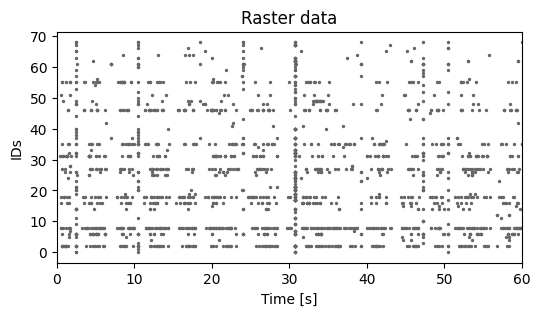

In [18]:
times = spike_pd_df_channel_replaced["time"].values
ids = spike_pd_df_channel_replaced["channel"].values
print(times[0:20:5])
print(np.shape(times))
print(ids)
print(np.shape(ids))

plt.figure(figsize = (6, 3))
plt.scatter(times, ids, s=2, c=[[.4,.4,.4]])
#plt.yticks(np.unique(ids)[::5])
plt.xlim([0,60])
#plt.xticks([0,15,30])
plt.ylabel('IDs')
plt.xlabel('Time [s]')
plt.title('Raster data')
plt.show()

In [19]:
from spycon.coninf import Smoothed_CCG
con_method = Smoothed_CCG() #This has an alpha parameter that can be changed
spycon_result = con_method.infer_connectivity(times, ids)
spycon_result.save("spycon_test_result", "data/")

  0%|          | 18/4692 [00:00<00:26, 175.38it/s]/home/mxwbio/miniconda3/envs/nathan_senior_project/lib/python3.13/site-packages/spycon/coninf/sci_sccg.py:273: RuntimeWarning: invalid value encountered in log
  logpfast_max = numpy.log(-numpy.expm1(logpfast_max))
100%|██████████| 4692/4692 [00:30<00:00, 153.28it/s] 


In [20]:
spycon_result = spycon.spycon_result.load_connectivity_result("spycon_test_result", "data/")

In [21]:
print(spycon_result.nodes)
print(spycon_result.threshold)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68]
[9.39266193]


DiGraph with 69 nodes and 4692 edges
DiGraph with 69 nodes and 24 edges


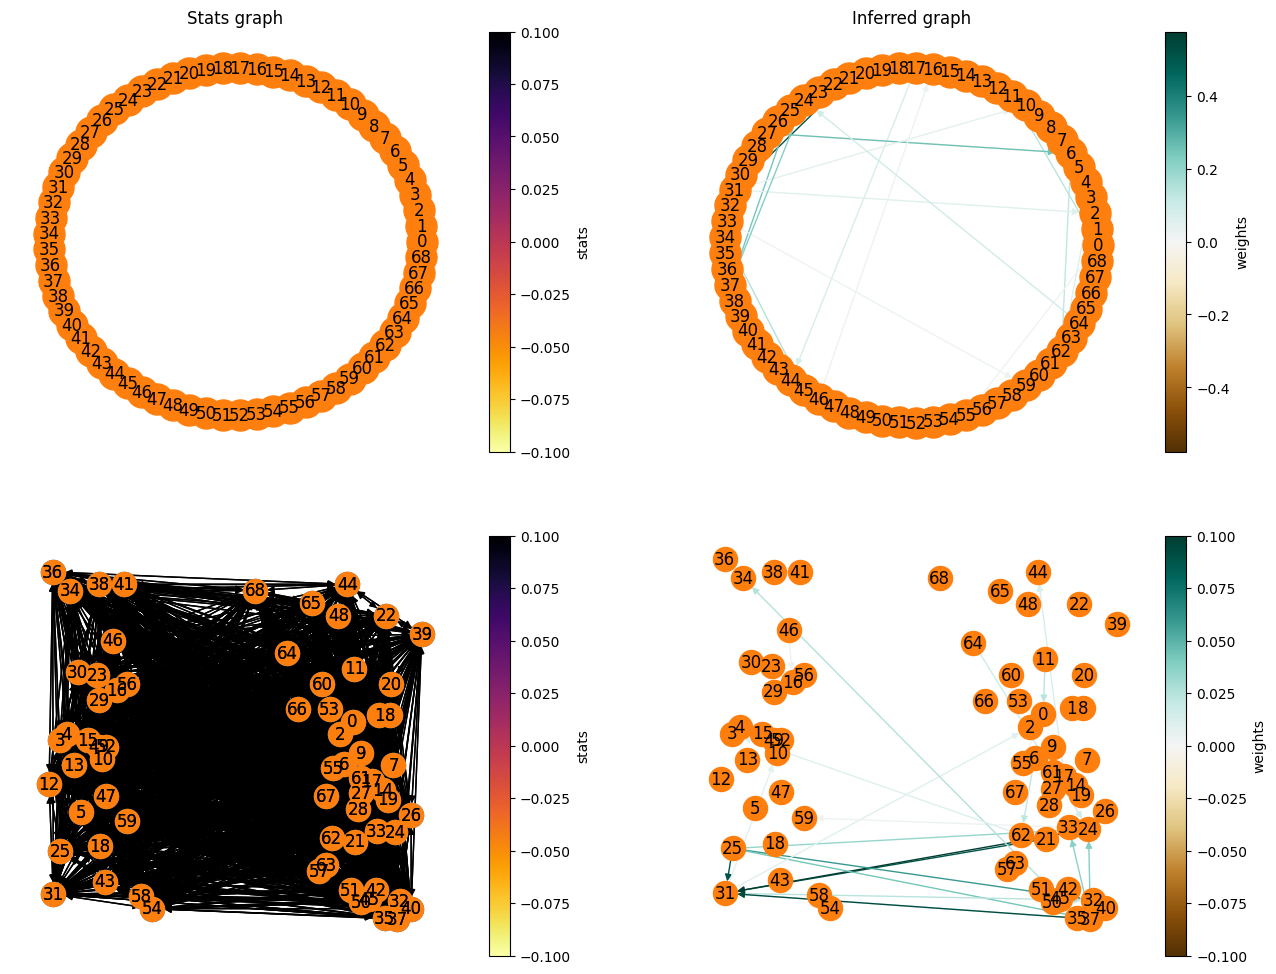

In [22]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(221)
g1 = spycon_result.draw_graph(graph_type='stats', ax=ax1)
print(g1)
pos1 = nx.circular_layout(g1)
for i in mapping_pd_df_channel_replaced.index:
    pos1[i] = np.array(mapping_pd_df_channel_replaced.loc[i, ["x", "y"]] )

ax1.set_title('Stats graph')
ax2 = fig.add_subplot(222)
g2 = spycon_result.draw_graph(graph_type='weighted', ax=ax2)
print(g2)
pos2 = nx.circular_layout(g2)
for i in mapping_pd_df_channel_replaced.index:
    pos2[i] = np.array(mapping_pd_df_channel_replaced.loc[i, ["x", "y"]])
ax2.set_title('Inferred graph')

ax3=fig.add_subplot(223)
nx.draw(g1, pos1, with_labels=True)
cmap = plt.get_cmap("inferno_r")
weights = list(nx.get_edge_attributes(g1, "weight").values())
min_weight, max_weight = np.amin(weights), np.amax(weights)
norm = mpl.colors.Normalize(vmin=min_weight, vmax=max_weight)
nx.draw(g1, pos1, with_labels=True,
        node_color="C1",
        edge_color=weights,
        edge_vmin=min_weight,
        edge_vmax=max_weight,
        edge_cmap=cmap,
        )
plt.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
            ax = plt.gca(), 
            label="stats",
        )

ax4=fig.add_subplot(224)
cmap = plt.get_cmap("BrBG")
weights = list(nx.get_edge_attributes(g2, "weight").values())
max_weight = np.amax(np.absolute(weights))
norm = mpl.colors.Normalize(vmin=min_weight, vmax=max_weight)
nx.draw(g2, pos2, with_labels=True,
        node_color="C1",
        edge_color=weights,
        edge_vmin=-max_weight,
        edge_vmax=max_weight,
        edge_cmap=cmap,
        )
plt.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
            ax = plt.gca(), 
            label="weights",
        )
plt.show()

zero-size array to reduction operation maximum which has no identity


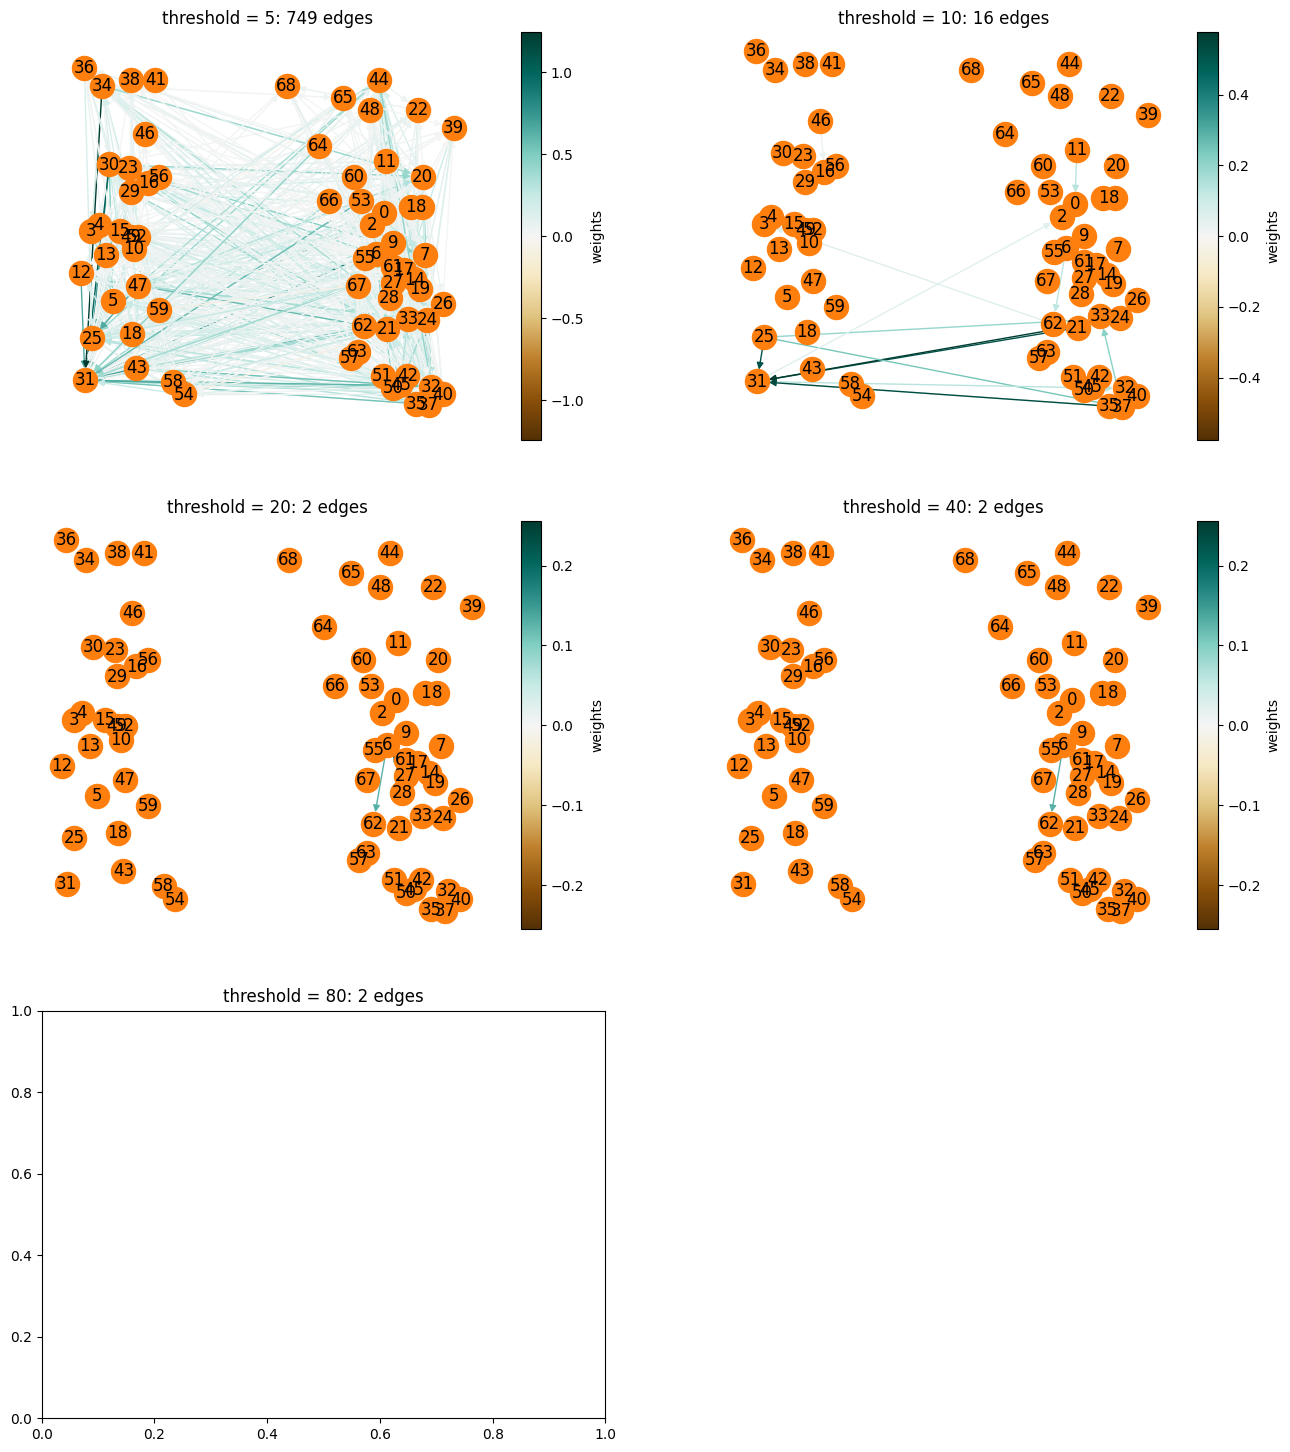

In [23]:
fig = plt.figure(figsize=(16,18))
for num, thresh in enumerate([5, 10, 20, 40, 80]):
    spycon_result.set_threshold(thresh)
    ax = plt.subplot(3, 2, num+1)
    
    try:
        g = spycon_utils.draw_graph_with_mapping(spycon_result, mapping_pd_df_channel_replaced, "weighted", ax = ax)
    except Exception as err:
        print(err)
    plt.title("threshold = " + str(thresh) + ": " + str(len(g.edges)) + " edges")
plt.show()